# HW2A: Alignment with IBM Model 1


In [22]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import math
import matplotlib.pyplot as plt # graphs and figures
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import string
from collections import Counter
from itertools import product
import tqdm.notebook
import pickle

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Data

We'll start out by using a toy dataset. Please see [these slides](https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf) for a more complete coverage of IBM Model 1, and feel free to check out Philipp Koehn's book _Statistical Machine Translation_. 

In [23]:
aligned_data = [
    (["das", "haus"], ["the", "house"]),
    (["das", "buch"], ["the", "book"]),
    (["ein", "buch"], ["a", "book"]),
]

In [24]:
print(aligned_data)

[(['das', 'haus'], ['the', 'house']), (['das', 'buch'], ['the', 'book']), (['ein', 'buch'], ['a', 'book'])]


## Alignment Model

Fill in the code for IBM Model 1 below. A correct implementation should achieve perplexity 4096 on the first iteration and perplexity around 70 by the tenth iteration, for the toy dataset above. Note that we'll be grading you only on the generated `self.translation_probabilities`, so the probability and perplexity functions only exist for you to check the correctness of your own implementation. You may wish to comment them out during implementation and check that `self.translation_probabilities` looks reasonable instead.

In [25]:
class IBMModel1:
    def __init__(self, data, num_iterations=10, epsilon=1.0, compute_perplexity=True):
        self.data = data # aligned corpus as shown above
        self.num_iterations = num_iterations # iterations of expectation-maximization
        self.epsilon = epsilon
        self.compute_perplexity = compute_perplexity
        
        # Preprocess bitext data:
        self.source_words, self.target_words = set(), set()
        for (source,target) in self.data:
            self.source_words.update(source)
            self.target_words.update(target)
        
        # Initialize uniform probabilities:
        self.translation_probs = {(s,t): 1.0/len(self.target_words)
                                  for s,t in product(self.source_words, self.target_words)}
        

    def e_step(self):
        # YOUR SOLUTION HERE
        # - Iterate over paired sentences in the data and compute:
        # - (1) counts, the number of times a source word is translated into a target word,
        #       weighted by alignment probabilities
        # - (2) total, the sum of counts over all possible target words
        # See slide 32 for more information: https://cal-cs288.github.io/sp20/slides/cs288_sp20_05_statistical_translation_4up.pdf

        # BEGIN SOLUTION

        sentence_total = dict()

        # 1) counts, the number of times a source word is translated into a target word, weighted by alignment probabilities
        counts = dict()
        # (2) total, the sum of counts over all possible target words
        total = dict()
        # Iterate over paired sentences in the data and compute
        # from slide 32: the code is as follows: 
        for foreign_sentence, english_sentence in self.data:

            for english_words in english_sentence:
                sentence_total[english_words] = 0

                for foreign_words in foreign_sentence:
                    sentence_total[english_words] = sentence_total[english_words] + self.translation_probs[(foreign_words,english_words)]

            for english_words in english_sentence:

                for foreign_words in foreign_sentence:
                    value = self.translation_probs[(foreign_words, english_words)] / sentence_total[english_words]

                    counts[(foreign_words, english_words)] = counts.get((foreign_words, english_words), 0) + value

                    total[foreign_words] = total.get(foreign_words, 0) + value
                
        return counts, total
        # END SOLUTION
        

    def m_step(self, counts, total):
        # YOUR SOLUTION HERE
        # - Update self.translation_probs using counts and total

        # BEGIN SOLUTION

        self.translation_probs = {(source, target): counts.get((source, target), 0) / total[source] 
                                  for source, target in product(self.source_words, self.target_words)}
                                  
        # END SOLUTION
        

    def train(self):
        # Run EM for self.num_iterations:
        for idx in tqdm.tqdm(range(self.num_iterations)):
            if self.compute_perplexity: 
                print("Iteration: {} | Perplexity: {}".format(idx, self.perplexity()))
            counts, total = self.e_step()
            self.m_step(counts, total)
        if self.compute_perplexity:
            print("Iteration: {} | Perplexity: {}".format(self.num_iterations, self.perplexity()))


        # # MY CODE: Check the probabilities 
        # print("\n")
        # for idx in tqdm.tqdm(range(self.num_iterations)):
        #   print("\n")
        #   print("probabilities: {} ".format(self.translation_probs))


    def probability(self, source, target):
        # YOUR SOLUTION HERE
        # - Use the normalization trick from lecture to efficiently compute probabilities
        # - We'll use self.epsilon here, which is defined in the initialization

        # BEGIN SOLUTION
        # Using the normalization trick from class:  
        product_of_the_sum_of_probabilities = 1
        for english_word in target:
            sum_of_probabilities = 0

            for foreign_word in source:
                sum_of_probabilities += self.translation_probs[(foreign_word, english_word)]

            product_of_the_sum_of_probabilities *= sum_of_probabilities

        # We'll use self.epsilon here, which is defined in the initialization
        return product_of_the_sum_of_probabilities * self.epsilon / len(source) ** len(target)

        # END SOLUTION
        

    def perplexity(self):
        # YOUR SOLUTION HERE
        # - Iterate over each pair of sentences in the dataset
        # - Call self.probability and compute a sum in log space
        # - Feel free to comment this out while testing your initial model

        # BEGIN SOLUTION

        return 2 ** (-sum([math.log2(self.probability(pair[0], pair[1])) for pair in self.data]))

        # END SOLUTION
        

    def get_alignment(self, source, target):
        # YOUR SOLUTION HERE
        # - Find the best word alignment for a source, target pair
        # - Output a list of [(source_idx, target_idx)]
        #   For example: (["ein", "buch"], ["a", "book"])
        #   should have an alignment [(0,0), (1,1)]
        
        # BEGIN SOLUTION
        best_word_alignment = list()

        for i in range(len(target)):
            index = np.argmax([self.translation_probs.get((s, target[i]), 0) for s in source])
            best_word_alignment.append((i, index))
            
        return best_word_alignment
        # END SOLUTION


ibm = IBMModel1(aligned_data)
ibm.train()
assert(ibm.get_alignment(["ein", "buch"], ["a", "book"]) == [(0, 0), (1, 1)])
with open("example_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:00<00:00, 9664.29it/s]

Iteration: 0 | Perplexity: 4096.0
Iteration: 1 | Perplexity: 202.27160493827165
Iteration: 2 | Perplexity: 148.579719533778
Iteration: 3 | Perplexity: 114.97728367667098
Iteration: 4 | Perplexity: 94.55365015392323
Iteration: 5 | Perplexity: 82.33392683842199
Iteration: 6 | Perplexity: 75.05039472109713
Iteration: 7 | Perplexity: 70.70850570939692
Iteration: 8 | Perplexity: 68.11819483523485
Iteration: 9 | Perplexity: 66.57100072682941
Iteration: 10 | Perplexity: 65.64416020074577


## Visualization and Analysis

Write code to visualize alignments and rerun the IBM model on a (very slightly larger) toy dataset:

100%|██████████| 10/10 [00:00<00:00, 1746.68it/s]

Iteration: 0 | Perplexity: 1628413597910461.5
Iteration: 1 | Perplexity: 189338839378.3891
Iteration: 2 | Perplexity: 39436268160.37859
Iteration: 3 | Perplexity: 13371159789.970629
Iteration: 4 | Perplexity: 6500890054.420371
Iteration: 5 | Perplexity: 4032796830.798999
Iteration: 6 | Perplexity: 2928993250.6301746
Iteration: 7 | Perplexity: 2354400387.609296
Iteration: 8 | Perplexity: 2021731747.1772301
Iteration: 9 | Perplexity: 1813803527.681711
Iteration: 10 | Perplexity: 1676193076.3822927


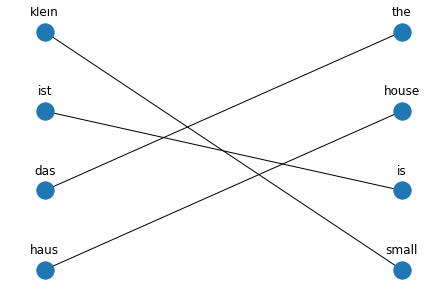

In [26]:
import networkx as nx
from networkx.algorithms import bipartite

def visualize_alignment(alignment, source, target):
    # YOUR SOLUTION HERE
    # BEGIN ALIGNMENT
    
    Graph = nx.Graph()
    Graph.add_nodes_from(source, bipartite=0)
    Graph.add_nodes_from(target, bipartite=1)
    Graph.add_edges_from([(source[indices[1]], target[indices[0]]) for indices in alignment])
    positions = {node:[0, -i] for i, node in enumerate(source)}
    positions.update({node:[1, -i] for i, node in enumerate(target)})
    
    nx.draw(Graph, positions, with_labels=False)

    for position in positions:
        positions[position][1] += 0.25

    nx.draw_networkx_labels(Graph, positions)

    # END ALIGNMENT

aligned_data = [
    (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
    (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
    (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),
    (['das', 'haus'], ['the', 'house']),
    (['das', 'buch'], ['the', 'book']),
    (['ein', 'buch'], ['a', 'book'])
]
ibm = IBMModel1(aligned_data)
ibm.train()
alignment = ibm.get_alignment(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])
# print(alignment)
visualize_alignment(alignment, ['klein', 'ist', 'das', 'haus'],  ['the', 'house', 'is', 'small'])

We'll now run the IBM model on a significantly larger dataset to showcase its failure modes:

In [27]:
!pip install sentencepiece torchtext==0.8.1
import sentencepiece
import torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [28]:
# Load the Multi30K translation dataset:
extensions = [".de", ".en"]
source_field = torchtext.data.Field(tokenize=lambda x: x)
target_field = torchtext.data.Field(tokenize=lambda x: x)
training_data, validation_data, test_data = torchtext.datasets.Multi30k.splits(
    extensions, [source_field, target_field], root=".")

/usr/local/lib/python3.8/dist-packages/torchtext/data/field.py:150: UserWarning: Field class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('{} class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.'.format(self.__class__.__name__), UserWarning)
/usr/local/lib/python3.8/dist-packages/torchtext/data/example.py:78: UserWarning: Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.
  warnings.warn('Example class will be retired soon and moved to torchtext.legacy. Please see the most recent release notes for further information.', UserWarning)


In [29]:
def preprocess(sentence):
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) # strip punctuation
    return sentence.strip().lower().split()

aligned_data = []
for example in training_data[:1000]:
    source = preprocess(example.src)
    target = preprocess(example.trg)
    aligned_data.append((source, target))

ibm = IBMModel1(aligned_data, compute_perplexity=False)
ibm.train()
with open("multi30k_alignments.pkl", "wb") as outfile:
    pickle.dump(ibm.translation_probs, outfile, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 10/10 [00:55<00:00,  5.60s/it]


In [30]:
# Making sure the model learned something:
examples = [
    ("hund", "dog"),
    ("hund", "cat"),
    ("ein", "a"),
    ("ein", "the"),
    ("frau", "woman"),
    ("frau", "man"),
]


for example in examples:
    print(str(example) + ": " + str(ibm.translation_probs[example]))

('hund', 'dog'): 0.9765105915208369
('hund', 'cat'): 1.0745541756409012e-16
('ein', 'a'): 0.904016367677722
('ein', 'the'): 0.0002091328743299106
('frau', 'woman'): 0.9528437741343648
('frau', 'man'): 2.454275253390026e-07


From this larger dataset: find at least one sentence where the IBM alignment model performs reasonably well, and find another one where it fails catastrophically, and include alignment visualizations for both examples in your report. You may want to consult a [German-English dictionary](https://www.collinsdictionary.com/us/dictionary/english-german) for this part of the problem. Provide a brief explanation for why the alignment model did poorly on the failure case.

100%|██████████| 10/10 [01:03<00:00,  6.36s/it]


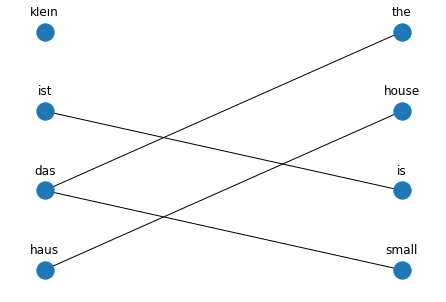

In [31]:
##Just Some visualizations
# (['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small']),
#  (['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big']),
#  (['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small']),

bm = IBMModel1(aligned_data)
ibm.train()
alignment = ibm.get_alignment(['klein', 'ist', 'das', 'haus'], ['the', 'house', 'is', 'small'])
# print(alignment)
visualize_alignment(alignment, ['klein', 'ist', 'das', 'haus'],  ['the', 'house', 'is', 'small'])

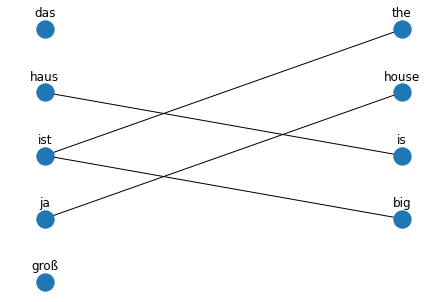

In [32]:
visualize_alignment(alignment, ['das', 'haus', 'ist', 'ja', 'groß'], ['the', 'house', 'is', 'big'])


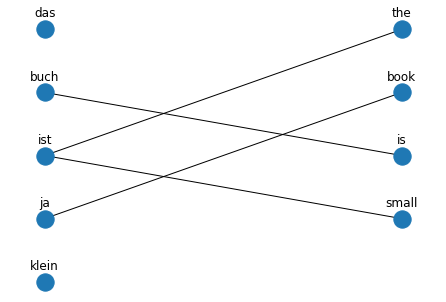

In [33]:
visualize_alignment(alignment, ['das', 'buch', 'ist', 'ja', 'klein'], ['the', 'book', 'is', 'small'])

In [34]:
print(len(aligned_data))

1000


In [35]:
print(aligned_data[0])

(['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche'], ['two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes'])


In [36]:
print(type(aligned_data))

<class 'list'>


In [37]:
print(aligned_data[:2])

[(['zwei', 'junge', 'weiße', 'männer', 'sind', 'im', 'freien', 'in', 'der', 'nähe', 'vieler', 'büsche'], ['two', 'young', 'white', 'males', 'are', 'outside', 'near', 'many', 'bushes']), (['mehrere', 'männer', 'mit', 'schutzhelmen', 'bedienen', 'ein', 'antriebsradsystem'], ['several', 'men', 'in', 'hard', 'hats', 'are', 'operating', 'a', 'giant', 'pulley', 'system'])]


In [40]:
words_to_search = ['ist']

for word in words_to_search:
    print(f"{word} appears in the following tuples of lists:")
    for tuple_of_lists in aligned_data:
        for sublist in tuple_of_lists:
            if word in sublist:
                print(tuple_of_lists)
                break

ist appears in the following tuples of lists:
(['ein', 'mann', 'liegt', 'auf', 'der', 'bank', 'an', 'die', 'auch', 'ein', 'weißer', 'hund', 'angebunden', 'ist'], ['a', 'man', 'lays', 'on', 'the', 'bench', 'to', 'which', 'a', 'white', 'dog', 'is', 'also', 'tied'])
(['ein', 'großes', 'bauwerk', 'ist', 'kaputt', 'gegangen', 'und', 'liegt', 'auf', 'einer', 'fahrbahn'], ['a', 'large', 'structure', 'has', 'broken', 'and', 'is', 'laying', 'in', 'a', 'roadway'])
(['ein', 'mann', 'der', 'barfuß', 'ist', 'olivgrüne', 'kurze', 'hosen', 'trägt', 'auf', 'einem', 'kleinen', 'propangasgrill', 'hotdogs', 'grillt', 'und', 'gleichzeitig', 'eine', 'blaue', 'kunststofftasse', 'hält'], ['a', 'barefooted', 'man', 'wearing', 'olive', 'green', 'shorts', 'grilling', 'hotdogs', 'on', 'a', 'small', 'propane', 'grill', 'while', 'holding', 'a', 'blue', 'plastic', 'cup'])
(['ein', 'weißer', 'hund', 'ist', 'kurz', 'davor', 'ein', 'gelbes', 'hundespielzeug', 'zu', 'fangen'], ['a', 'white', 'dog', 'is', 'about', 'to',

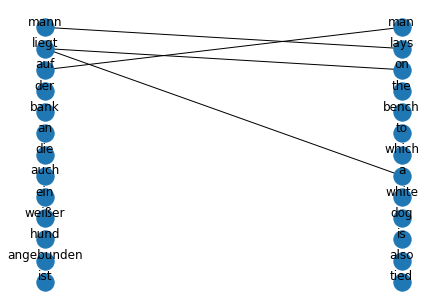

In [41]:
visualize_alignment(alignment,['ein', 'mann', 'liegt', 'auf', 'der', 'bank', 'an', 'die', 'auch', 'ein', 'weißer', 'hund', 'angebunden', 'ist'], 
                    ['a', 'man', 'lays', 'on', 'the', 'bench', 'to', 'which', 'a', 'white', 'dog', 'is', 'also', 'tied'])


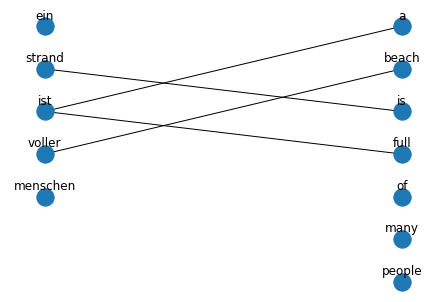

In [45]:
visualize_alignment(alignment,['ein', 'strand', 'ist', 'voller', 'menschen'], ['a', 'beach', 'is', 'full', 'of', 'many', 'people'])